In [1]:
# Data is placed in /app/data/

# this code read all the csv from data.
import pandas as pd

root_path = "/app/data/"

customers_df = pd.read_csv(root_path + 'olist_customers_dataset.csv')
items_df = pd.read_csv(root_path + 'olist_order_items_dataset.csv')
payments_df = pd.read_csv(root_path + 'olist_order_payments_dataset.csv')
orders_df = pd.read_csv(root_path + 'olist_orders_dataset.csv')
products_df = pd.read_csv(root_path + 'olist_products_dataset.csv')
sellers_df = pd.read_csv(root_path + 'olist_sellers_dataset.csv')
categories_df = pd.read_csv(root_path + 'product_category_name_translation.csv')

In [2]:
# create a super data frame contianing the sub data frames
dataframes = {'customers': customers_df,
              'items': items_df, 
              'payments': payments_df, 
              'orders': orders_df, 
              'products': products_df, 
              'sellers': sellers_df, 
              'categories': categories_df}
for i, j in dataframes.items():
    print(f'{i:12s} dataframe: {str(len(j)):7s} rows')

customers    dataframe: 99441   rows
items        dataframe: 112650  rows
payments     dataframe: 103886  rows
orders       dataframe: 99441   rows
products     dataframe: 32951   rows
sellers      dataframe: 3095    rows
categories   dataframe: 71      rows


In [3]:
# products_df contains 73 unique categories, while categories_df contains 71: that's why we use left, 
# for missing categories we keep the category name in Portuguese.
products_df = pd.merge(products_df, categories_df, on='product_category_name', how='left')
# Delete 'product_category_name' column
del products_df['product_category_name']
# Delete  the categories_df dataframe
del categories_df
# Rename the column
products_df.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)

In [4]:
# Get ration of number of customer to number of orders
customers = customers_df['customer_unique_id'].nunique()
orders = orders_df.order_id.nunique()
print("number of customers:", customers)
print("number of orders:   ", orders)
print(f"number of orders per cusotmer: {orders / customers:.2f}")

number of customers: 96096
number of orders:    99441
number of orders per cusotmer: 1.03


In [5]:
# Merge all dataframes to one.
df = pd.merge(orders_df, customers_df, on='customer_id')
df = df.merge(items_df, on='order_id')
df = df.merge(payments_df, on='order_id')
df = df.merge(products_df, on='product_id')
df = df.merge(sellers_df, on='seller_id')
df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP


In [6]:
df['order_purchase_year'] = pd.to_datetime(df['order_purchase_timestamp']).dt.year
df['order_purchase_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
df['order_purchase_day'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day
df['order_purchase_hour'] = pd.to_datetime(df['order_purchase_timestamp']).dt.hour
# Selecting the attributes that we want to keep:
columns = ['order_status', 'customer_state', 'order_item_id', 'price', 
           'freight_value', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 
           'order_purchase_year', 'order_purchase_month', 'order_purchase_day', 'order_purchase_hour']

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing to convert categorialc attributes to one hot encode form and applying z-score normaization to scalar variables.

num_attributes = ['order_item_id', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 
                  'payment_value', 'order_purchase_year', 'order_purchase_month', 'order_purchase_day', 'order_purchase_hour']
cat_attributes = ['order_status', 'customer_state', 'payment_type']

pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df)
df_prepared

<117601x48 sparse matrix of type '<class 'numpy.float64'>'
	with 1528813 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.decomposition import PCA

df_prepared = df_prepared.toarray()
# Preserving 95% of the variance
pca = PCA(n_components=0.95)
df_reduced = pca.fit_transform(df_prepared)
df_reduced.shape

(117601, 13)

In [9]:
from sklearn.cluster import KMeans
# Inertia: In the context of K-Means, inertia measures how tightly the clusters are packed. It is defined as the sum of squared distances
# between each data point and its assigned cluster centroid. Lower inertia indicates that the clusters are more compact, while higher 
# inertia suggests more spread-out clusters.
k_range = range(2, 15)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_reduced)
                for k in k_range]
inertias = [model.inertia_ for model in kmeans_per_k]

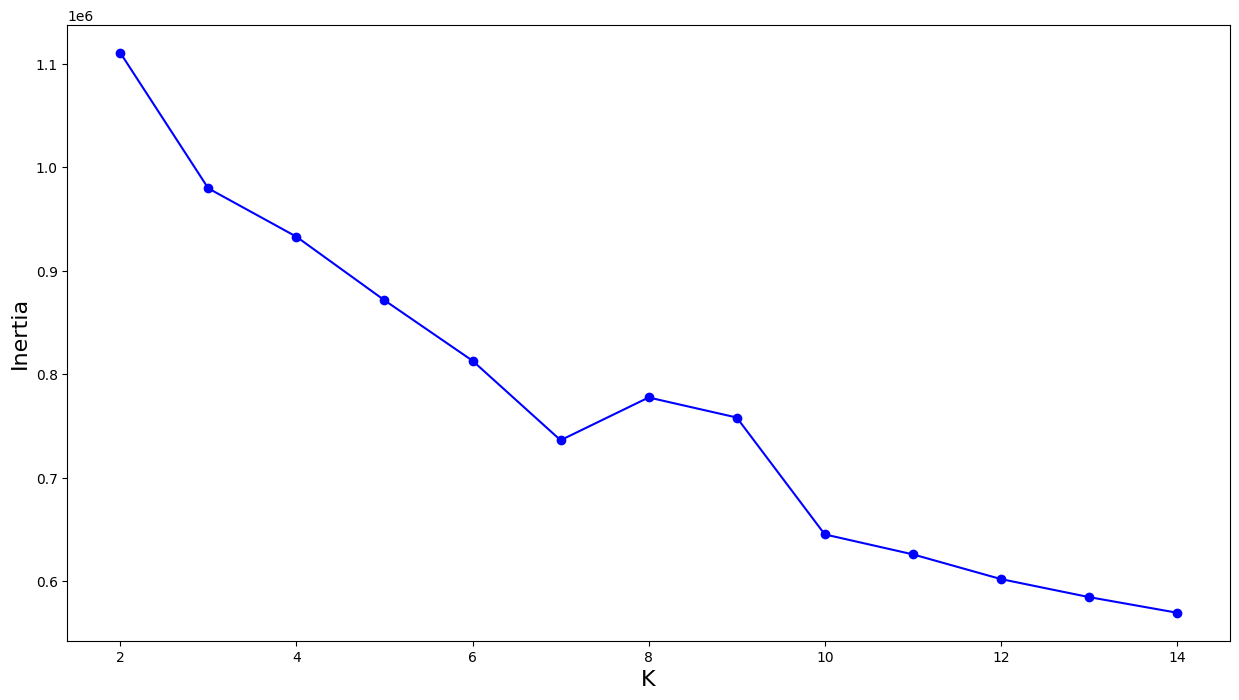

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('K', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.show()

In [11]:
from sklearn.metrics import silhouette_score
# The silhouette score measures how similar an object is to its own cluster compared to other clusters. 
# The score ranges from -1 to +1, +1 being most appropriate clustering and vice cersa
silhouette_scores = [silhouette_score(df_reduced, model.labels_)
                      for model in kmeans_per_k]

In [18]:
import numpy as np
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]
# Best number of clusters
best_k

3

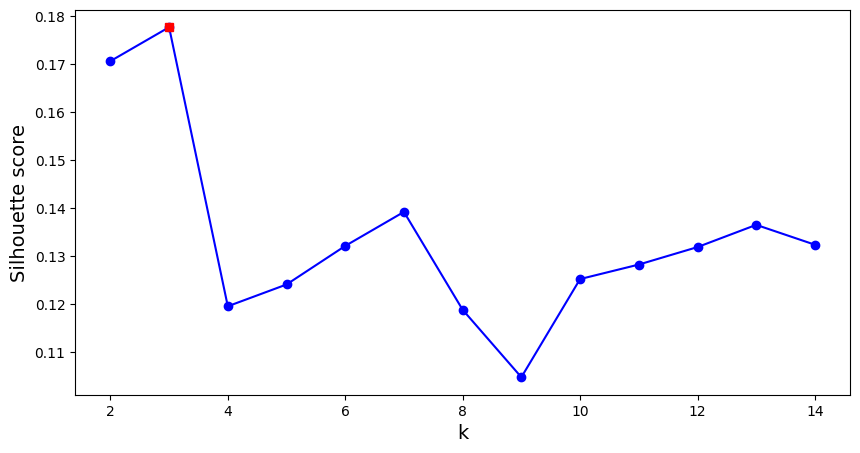

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 15), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, 'rs')
plt.show()

In [20]:
best_model = kmeans_per_k[best_index]
best_model

KMeans(n_clusters=3, random_state=42)

In [21]:
y_pred = best_model.fit_predict(df_reduced)

In [22]:
for i in range(best_k):
    print(f"cluster {i + 1} contains: {np.sum(y_pred == i)} customers")

cluster 1 contains: 5130 customers
cluster 2 contains: 60785 customers
cluster 3 contains: 51686 customers


In [23]:
from sklearn.manifold import TSNE
# t-SNE is particularly effective for visualizing high-dimensional datasets. It works by minimizing the divergence between probability
# distributions that represent pairwise similarities of the data points in high-dimensional space and the corresponding distributions in 
# low-dimensional space. It is particularly good at preserving local structure, making it useful for visualizing clusters in the data.

tsne = TSNE(n_components=2, random_state=42)
df_reduced = tsne.fit_transform(df_prepared)

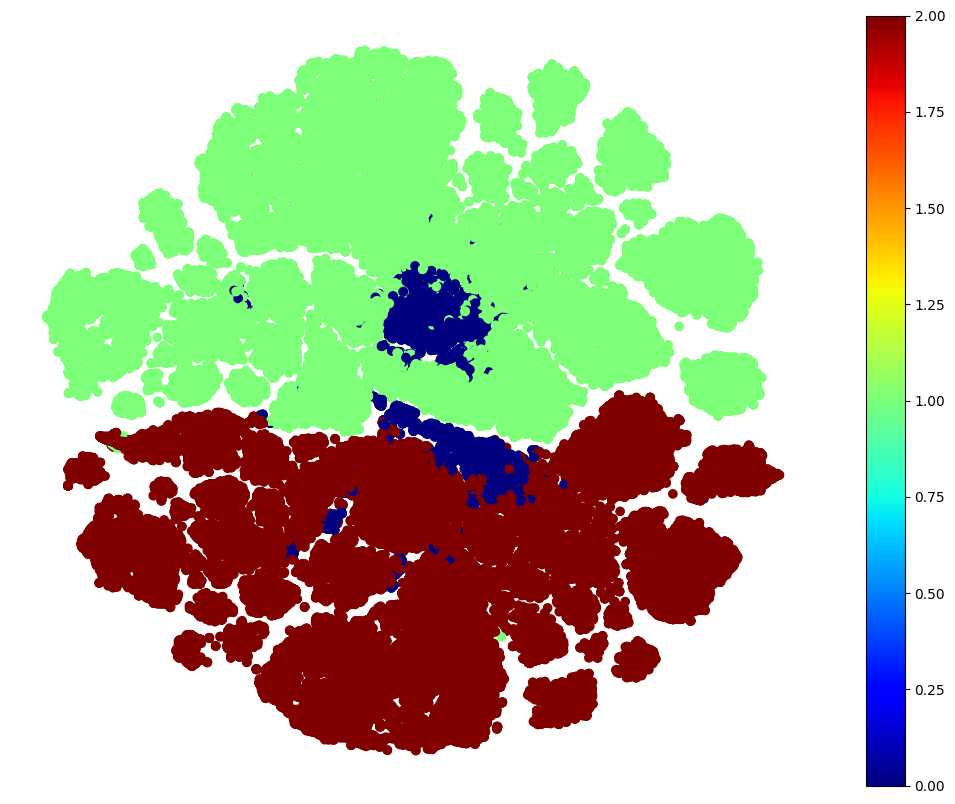

In [24]:
plt.figure(figsize=(13,10 ))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1],c=y_pred, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()